# Código do TCC de Paulo de Tarso, da EMAp FGV

## Parâmetros

In [1]:
#Parâmetros
inicio_atas = 104 #Utilizarei as atas a partir de 2005
final_atas = 207

total_atas = final_atas - inicio_atas + 1
atas = range(inicio_atas,final_atas+1)

path = "D:/Users/paulotarsosantos/Documents/Documentos/TCC/"

## Pacotes

In [2]:
import nltk
#Se for preciso, executar o comando abaixo
#nltk.download()

#Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

import unicodedata
import string
from sklearn.metrics import confusion_matrix
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import CountVectorizer as CV

## Códigos auxiliares
### Código para remover símbolos das strings

In [3]:
def clean_string(s):
    s = s.replace("\n"," ")
    return ''.join(x for x in unicodedata.normalize('NFKD', s)
                   if x in string.ascii_letters + " ").lower()

## Tokenização dos textos

### Obter textos dos arquivos

In [4]:
texts = []

#Ir para a pasta com os arquivos
os.chdir(path + "Atas/")

#Obter o texto dos arquivos
for n in atas:
    file = open("COPOM_" + str(n) + ".txt")
    texts.append(clean_string(file.read()))
    file.close()

#Voltar uma pasta
os.chdir("..")

### Vetorizar os textos obtidos

#### Stopwords

In [5]:
sw = [clean_string(word) for word in 
             open("stopwords.txt",encoding="utf-8").read().splitlines()[1:]]

#### Vectorização

In [6]:
#Exemplo
textos = ["COPOM decide cortar a meta da Selic em 100 bps.",
         "COPOM acredita no aceleração da economia do país e reduz a meta em 200 bps.",
         "COPOM defende que uma taxa de juros menor gera uma aceleração do investimento no país."]

print("Textos:\n")
[print('"' + texto + '"') for texto in textos]

print("\nAlgumas stopwords:")
print(sw[10:20])

textos = [clean_string(texto) for texto in textos]

from sklearn.feature_extraction.text import CountVectorizer as CV

vetorizador = CV(stop_words=sw,min_df=2)
vetores = vetorizador.fit_transform(textos).toarray()

print("\nVocabulário:\n")
print(vetorizador.get_feature_names())

print("\nVetores de cada texto:")
dict(zip(textos,[str(elt) for elt in vetores]))

Textos:

"COPOM decide cortar a meta da Selic em 100 bps."
"COPOM acredita no aceleração da economia do país e reduz a meta em 200 bps."
"COPOM defende que uma taxa de juros menor gera uma aceleração do investimento no país."

Algumas stopwords:
['do', 'da', 'em', 'um', 'para', 'e', 'com', 'nao', 'uma', 'os']

Vocabulário:

['aceleracao', 'copom', 'meta', 'pais']

Vetores de cada texto:


{'copom acredita no aceleracao da economia do pais e reduz a meta em  bps': '[1 1 1 1]',
 'copom decide cortar a meta da selic em  bps': '[0 1 1 0]',
 'copom defende que uma taxa de juros menor gera uma aceleracao do investimento no pais': '[1 1 0 1]'}

In [136]:
vectorizer = CV(stop_words=sw,min_df=50)
arrays = vectorizer.fit_transform(texts).toarray()
#d_arrays = dict(zip(range(inicio_atas,final_atas+1),arrays))

## Obter os valores das variações na meta da Selic em cada reunião do Copom

In [137]:
file = open("Cortes.txt")
cortes = [int(line.split(";")[2]) for line in file.read().splitlines()[1:]]
cortes = [int(n/abs(n)) if n != 0 else 0 for n in cortes]
cortes.reverse()
file.close()

## Análise exploratória

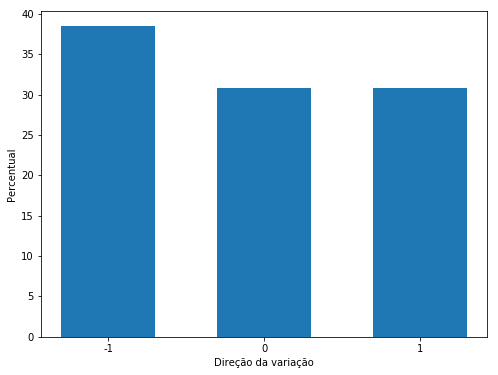

In [138]:
#Plot das quantidades por classe
plt.figure(figsize=[8,6])
plt.bar([-1,0,1],[cortes.count(elt)/len(cortes)*100 for elt in [-1,0,1]],width=0.6)
plt.xticks([-1,0,1],["-1","0","1"])
plt.xlabel("Direção da variação")
plt.ylabel("Percentual")
plt.show()

In [139]:
aux = list(zip(arrays[:-1],cortes))

cortes_aux = [elt[1] for elt in aux]
arrays_aux = [elt[0] for elt in aux]

from sklearn.linear_model import LogisticRegression as LR

X_train,X_test,y_train,y_test = tts(arrays_aux[:-1],cortes_aux[:-1],train_size=0.6)
classifier = LR()
classifier.fit(X_train,y_train)

#Coeficientes da regressão logística
classifier_coefs = [str(round(value,3)) for value in classifier.coef_[0]]
coefs = list(zip(classifier_coefs,vectorizer.get_feature_names()))

coefs.sort(key=lambda x:float(x[0]))
min_n = coefs[:10]

coefs.reverse()
max_n = coefs[:10]

max_n,min_n

([('0.095', 'economia'),
  ('0.093', 'processo'),
  ('0.076', 'junho'),
  ('0.076', 'ante'),
  ('0.07', 'cenario'),
  ('0.069', 'flexibilizacao'),
  ('0.062', 'indicadores'),
  ('0.06', 'continuidade'),
  ('0.059', 'us'),
  ('0.054', 'aumento')],
 [('-0.079', 'precos'),
  ('-0.077', 'sobre'),
  ('-0.073', 'relacao'),
  ('-0.072', 'ritmo'),
  ('-0.066', 'setor'),
  ('-0.062', 'atingiu'),
  ('-0.062', 'vendas'),
  ('-0.06', 'pressoes'),
  ('-0.059', 'trajetoria'),
  ('-0.057', 'acima')])

In [107]:
confusion_matrix(y_test,classifier.predict(X_test),labels=[-1,0,1]),classifier.score(X_test,y_test)

(array([[13,  4,  0],
        [ 2, 10,  1],
        [ 1,  1,  9]]), 0.78048780487804881)

## Métodos de classificação
Me basearei nos modelos contidos na biblioteca Scikit Learn. Os modelos estão em http://scikit-learn.org/stable/supervised_learning.html.

#### Função que recebe o modelo desejado e retorna o score médio e o valor predito médio para a última reunião (não presente na amostra)

In [108]:
def RunModel(model,next_copom = False):
    classifier = model
    
    #Separação em dados para treino e dados para teste do modelo
    #(Aqui, utilizo até a antepenúltima reunião; a penúltima será
    #utilizada para prever o resultado da última).
    X_train,X_test,y_train,y_test = tts(arrays,cortes,train_size=0.6)

    #Treino do modelo nos dados
    classifier.fit(X_train,y_train)

    #Resultados
    score = classifier.score(X_test,y_test)
    if not next_copom:
        last_prediction = classifier.predict(arrays[-2])[0]
    else:
        last_prediction = classifier.predict(arrays[-1])[0]
    
    return [score,last_prediction]

In [109]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier as SGDC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.cross_decomposition import PLSRegression as PLSR
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.naive_bayes import BernoulliNB as BNB
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import BaggingClassifier as BC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.ensemble import VotingClassifier as VC
from sklearn.linear_model import LogisticRegression as LR

models = [LR(),LDA(),QDA(),KRR(),SVC(),SGDC(),KNC(),GPC(),PLSR(),
          GNB(),MNB(),BNB(),DTC(),BC(),RFC(),ETC(),ABC(),GBC(),MLPC(),
          VC(estimators=[('LDA', LDA()), ('ETC', ETC()),
                        ('GBC', GBC())], voting='hard')]

names = ["Generalized Linear Model","Linear Discriminant Analysis",
        "Quadratic Discriminant Analysis","Kernel Ridge Regression",
        "Support Vector Machine Classifier","Stochastic Gradient Descent",
        "K Nearest Neighbors","Gaussian Process",
         "Partial Least Squares Regressors","Gaussian Naive Bayes",
         "Multinomial Naive Bayes","Bernoulli Naive Bayes",
         "Decision Tree Classifier","Bagging meta-estimator",
        "Random Forest Classifier","Extremely Randomized Trees",
        "AdaBoost Classifier","Gradient Tree Boosting",
        "Multi-layer Perceptron Classifier","Voting Classifier"]

Rodar os modelos

In [110]:
results = []

for i in range(len(models)):
    
    results.append(RunModel(models[i]))

Ordenar e mostrar os resultados

In [111]:
scores = [result[0] for result in results]
last_predictions = [result[1] for result in results]

model_results = list(zip(names,scores,last_predictions))

model_results.sort(key=lambda x:x[1])
model_results.reverse()

In [112]:
model_results

[('Bagging meta-estimator', 0.7857142857142857, -1),
 ('Multinomial Naive Bayes', 0.73809523809523814, -1),
 ('Gaussian Naive Bayes', 0.7142857142857143, -1),
 ('Voting Classifier', 0.66666666666666663, -1),
 ('Extremely Randomized Trees', 0.66666666666666663, -1),
 ('Decision Tree Classifier', 0.6428571428571429, -1),
 ('Gradient Tree Boosting', 0.61904761904761907, -1),
 ('Random Forest Classifier', 0.61904761904761907, -1),
 ('Linear Discriminant Analysis', 0.61904761904761907, -1),
 ('Bernoulli Naive Bayes', 0.59523809523809523, -1),
 ('Kernel Ridge Regression', 0.55986435288231351, -0.99970641266674676),
 ('Generalized Linear Model', 0.54761904761904767, -1),
 ('AdaBoost Classifier', 0.5, -1),
 ('Support Vector Machine Classifier', 0.45238095238095238, -1),
 ('Multi-layer Perceptron Classifier', 0.42857142857142855, -1),
 ('Quadratic Discriminant Analysis', 0.42857142857142855, -1),
 ('K Nearest Neighbors', 0.38095238095238093, -1),
 ('Gaussian Process', 0.30952380952380953, -1),


In [113]:
file = open("Results.csv","w")
[file.write(names[i] + ";" + str(scores[i]) + ";" +
            str(last_predictions[i]) + "\n") for i in range(len(scores))]
file.close()

### Generalized Linear Model

In [114]:
from sklearn.linear_model import LinearRegression as LR
RunModel(LR(),1000)

[0.43746729340908852, -1.1467145516201525]

### Linear Discriminant Analysis

In [115]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
RunModel(LDA(),1000)

[0.52380952380952384, -1]

### Quadratic Discriminant Analysis

In [116]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
RunModel(QDA(),1000)

[0.30952380952380953, -1]

### Kernel Ridge Regression

In [117]:
from sklearn.kernel_ridge import KernelRidge as KRR
RunModel(KRR(),10000)

[0.61889372003055976, -0.79199511039309911]

### Support Vector Machine

In [118]:
from sklearn.svm import SVC
RunModel(SVC(),100)

[0.47619047619047616, -1]

### Stochastic Gradient Descent

In [119]:
from sklearn.linear_model import SGDClassifier as SGDC
RunModel(SGDC(),1000)

[0.47619047619047616, -1]

### Nearest Neighbors

In [120]:
from sklearn.neighbors import KNeighborsClassifier as KNC
RunModel(KNC(),1000)

[0.54761904761904767, -1]

### Gaussian Process

In [121]:
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
RunModel(GPC(),1000)

[0.33333333333333331, -1]

### Cross Decomposition

In [122]:
from sklearn.cross_decomposition import PLSRegression as PLSR
RunModel(PLSR(),1000)

[-1.2498138587635479, array([-3.26781179])]

### Gaussian Naive Bayes

In [123]:
from sklearn.naive_bayes import GaussianNB as GNB
RunModel(GNB(),1000)

[0.76190476190476186, -1]

### Multinomial Naive Bayes

In [124]:
from sklearn.naive_bayes import MultinomialNB as MNB
RunModel(MNB(),1000)

[0.52380952380952384, -1]

### Bernoulli Naive Bayes

In [125]:
from sklearn.naive_bayes import BernoulliNB as BNB
RunModel(BNB(),1000)

[0.59523809523809523, -1]

### Decision Tree Classifier

In [126]:
from sklearn.tree import DecisionTreeClassifier as DTC
RunModel(DTC(),1000)

[0.66666666666666663, -1]

### Bagging meta-estimator

In [127]:
from sklearn.ensemble import BaggingClassifier as BC
RunModel(BC(),100)

[0.7142857142857143, -1]

### Random Forest Classifier

In [128]:
from sklearn.ensemble import RandomForestClassifier as RFC
RunModel(RFC(),1000)

[0.66666666666666663, -1]

### Extremely Randomized Trees

In [129]:
from sklearn.ensemble import ExtraTreesClassifier as ETC
RunModel(ETC(),1000)

[0.73809523809523814, -1]

### AdaBoost Classifier

In [130]:
from sklearn.ensemble import AdaBoostClassifier as ABC
RunModel(ABC(),100)

[0.52380952380952384, 0]

### Gradient Tree Boosting

In [131]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
RunModel(GBC(),10)

[0.5714285714285714, -1]

### Multi-layer Perceptron Classifier
Neural Network with backpropagation

In [132]:
from sklearn.neural_network import MLPClassifier as MLPC
RunModel(MLPC(hidden_layer_sizes=(20, 5)),100)

[0.69047619047619047, -1]

### Grid Search Voting Classifier
Utiliza múltiplos modelos e encontra os pesos para cada modelo.

In [133]:
from sklearn.ensemble import VotingClassifier
RunModel(VC(estimators=[('LDA', LDA()), ('ETC', ETC()),
                        ('GBC', GBC())], voting='hard'),10,next_copom=True)

TypeError: RunModel() got multiple values for argument 'next_copom'